### Basic Modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import os
import h5py
import pickle
from typing import *
from functools import partial

In [2]:
from pathlib import Path
PATH = Path('data/top/')

In [3]:
trn_store = pd.HDFStore(PATH/'train.h5')

In [4]:
import torch

In [11]:
torch.cuda.current_device()

0

In [12]:
def load_df(store:pd.io.pytables.HDFStore, n_evts:Optional[int]=None, n_const:Optional[int]=None) -> pd.DataFrame:
    df = trn_store.select("table",stop=n_evts).drop(columns=['truthE','truthPX','truthPY','truthPZ','ttv'])
    if n_const is not None: df.drop(columns=[f for f in df.columns if f != 'is_signal_new' and int(f[f.find('_')+1:]) >= n_const], inplace=True)
    rename = {f:f'{f[f.find("_")+1:]}_{f[:f.find("_")].lower()}' for f in df.columns if f != 'is_signal_new'}
    rename['is_signal_new'] = 'gen_target'
    df.rename(columns=rename, inplace=True)
    return df

In [13]:
df = load_df(trn_store, 100000, 15)
train_feats = [f for f in df.columns if f != 'gen_target']
train_feats

['0_e',
 '0_px',
 '0_py',
 '0_pz',
 '1_e',
 '1_px',
 '1_py',
 '1_pz',
 '2_e',
 '2_px',
 '2_py',
 '2_pz',
 '3_e',
 '3_px',
 '3_py',
 '3_pz',
 '4_e',
 '4_px',
 '4_py',
 '4_pz',
 '5_e',
 '5_px',
 '5_py',
 '5_pz',
 '6_e',
 '6_px',
 '6_py',
 '6_pz',
 '7_e',
 '7_px',
 '7_py',
 '7_pz',
 '8_e',
 '8_px',
 '8_py',
 '8_pz',
 '9_e',
 '9_px',
 '9_py',
 '9_pz',
 '10_e',
 '10_px',
 '10_py',
 '10_pz',
 '11_e',
 '11_px',
 '11_py',
 '11_pz',
 '12_e',
 '12_px',
 '12_py',
 '12_pz',
 '13_e',
 '13_px',
 '13_py',
 '13_pz',
 '14_e',
 '14_px',
 '14_py',
 '14_pz']

In [14]:
from lumin.data_processing.pre_proc import fit_input_pipe

def proc_df(df:pd.DataFrame, train_feats:List[str]) -> None:
    df[train_feats] = df[train_feats].replace(0.0, np.nan)  # Don't bias preprocessing with non-existent tracks
    input_pipe = fit_input_pipe(df, train_feats, PATH/'input_pipe')
    df[train_feats] = input_pipe.transform(df[train_feats])  # Rescale and shift track momenta values

In [15]:
proc_df(df, train_feats)

/home/giles/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py:451: DataConversionWarning: Data with input dtype float32 were all converted to float64 by StandardScaler.
  Xt = transform.transform(Xt)


In [16]:
from lumin.data_processing.hep_proc import get_vecs

fpv = ['px', 'py', 'pz', 'e']
vecs = sorted(list(get_vecs(train_feats)))
fpv, vecs

(['px', 'py', 'pz', 'e'],
 ['0',
  '1',
  '10',
  '11',
  '12',
  '13',
  '14',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9'])

In [17]:
from lumin.data_processing.file_proc import df2foldfile
from lumin.nn.data.fold_yielder import *

def df2fy(df:pd.DataFrame, train_feats:List[str], vecs:Optional[List[str]]=None, feats_per_vec:Optional[List[str]]=None,
            row_wise:Optional[bool]=None, use_aug:bool=True) -> FoldYielder:
    df2foldfile(df=df, n_folds=10,
                cont_feats=train_feats, cat_feats=[], targ_feats='gen_target',
                matrix_feats_per_vec=feats_per_vec, matrix_vecs=vecs, matrix_row_wise=row_wise,
                savename=PATH/'train', targ_type='int', strat_key='gen_target')
    if vecs is None: return HEPAugFoldYielder(PATH/'train.hdf5') if use_aug else FoldYielder(PATH/'train.hdf5')
    else:            return FoldYielder(PATH/'train.hdf5')

In [18]:
train_fy = df2fy(df, train_feats, use_aug=True)

Saving fold 0 with 10000 events
Saving fold 1 with 10000 events
Saving fold 2 with 10000 events
Saving fold 3 with 10000 events
Saving fold 4 with 10000 events
Saving fold 5 with 10000 events
Saving fold 6 with 10000 events
Saving fold 7 with 10000 events
Saving fold 8 with 10000 events
Saving fold 9 with 10000 events
Augmenting via phi rotations
Augmenting via y flips
Augmenting via longitunidnal flips
Total augmentation multiplicity is 8


In [19]:
from lumin.nn.models.model_builder import ModelBuilder
from lumin.nn.models.model import Model
from lumin.nn.models.blocks.body import FullyConnected
from lumin.nn.models.helpers import CatEmbedder
from lumin.nn.models.blocks.head import *
from lumin.nn.models.blocks.head import AbsHead
from typing import *
from torch import nn

In [20]:
bs = 256
objective = 'classifier'
n_out = 1

def get_model_builder(fy:FoldYielder, depth:int, width:int, head:AbsHead=CatEmbHead) -> ModelBuilder:
    opt_args = {'opt':'adam', 'eps':1e-08}
    cat_embedder = CatEmbedder.from_fy(fy)
    body = partial(FullyConnected, depth=depth, width=width, act='swish')
    model_builder = ModelBuilder(objective, cont_feats=fy.cont_feats, n_out=n_out, cat_embedder=cat_embedder, 
                                 opt_args=opt_args, body=body, head=head)
    print(Model(model_builder))
    return model_builder

## DNN

In [21]:
model_builder = get_model_builder(train_fy, depth=4, width=50)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CatEmbHead()
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=60, out_features=50, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0

LR finder took 7.786s 


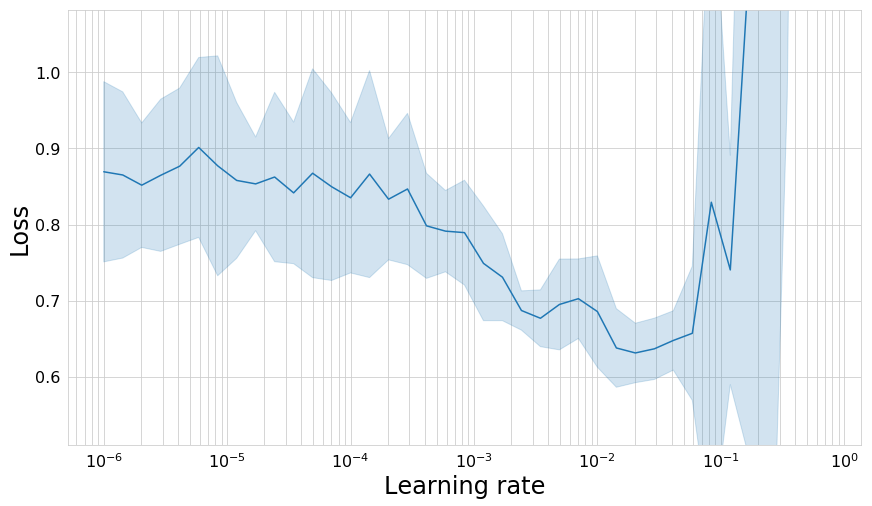

In [22]:
from lumin.optimisation.hyper_param import fold_lr_find

lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

In [23]:
from sklearn.metrics import roc_auc_score
from lumin.nn.metrics.eval_metric import EvalMetric

class AUC(EvalMetric):
    def __init__(self, wgt_name:Optional[str]=None, targ_name:str='targets'):
        super().__init__(targ_name=targ_name, wgt_name=wgt_name)

    def evaluate(self, fy:FoldYielder, idx:int, y_pred:np.ndarray) -> float:
        df = self.get_df(fy, idx, y_pred)
        return roc_auc_score(df['gen_target'], df['pred'])

In [24]:
from lumin.nn.callbacks.cyclic_callbacks import *
from functools import partial

callback_partials = [partial(OneCycle, lengths=[45, 90], lr_range=[1e-4, 1e-2], mom_range=[0.85, 0.95], interp='cosine')]
eval_metrics = {'AUC':AUC(wgt_name='weights')}

Training model 1 / 1, Val ID = 0


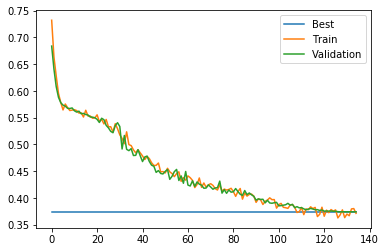

Early stopping after 135 epochs
Scores are: {'loss': 0.3742597699165344, 'AUC': 0.900951276608817}
Fold took 86.908s


______________________________________
Training finished
Cross-validation took 86.918s 


<Figure size 432x288 with 0 Axes>

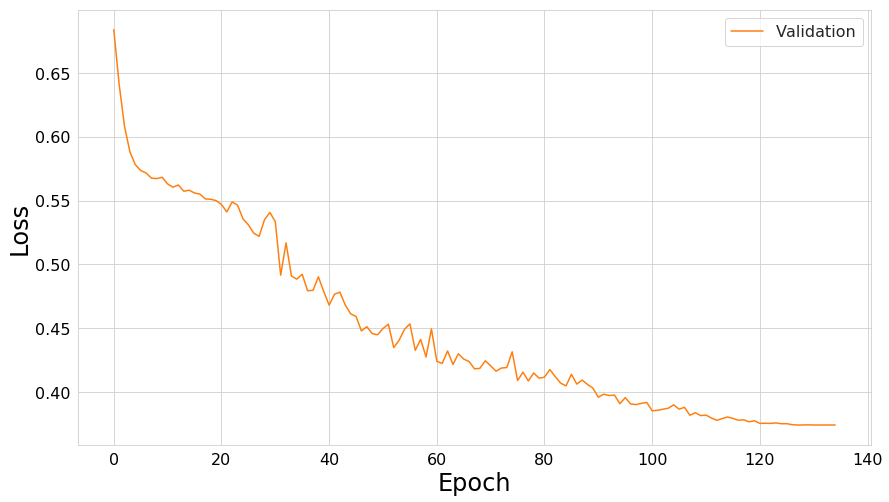

Mean loss = 0.3742597699165344±0.0
Mean AUC = 0.900951276608817±0.0
______________________________________



In [25]:
from lumin.nn.training.fold_train import fold_train_ensemble

_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

## RNN

In [27]:
head = partial(RecurrentHead, vecs=vecs, feats_per_vec=fpv,
               depth=1, width=10, rnn=nn.GRU, bidirectional=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): RecurrentHead(
    (rnn): GRU(4, 10, batch_first=True, bidirectional=True)
  )
  (1): FullyConnected(
    (layers): Sequential(
      (0): Sequential(
        (0): Linear(in_features=20, out_features=50, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=50, out_features=50, bias=Tr

LR finder took 8.479s 


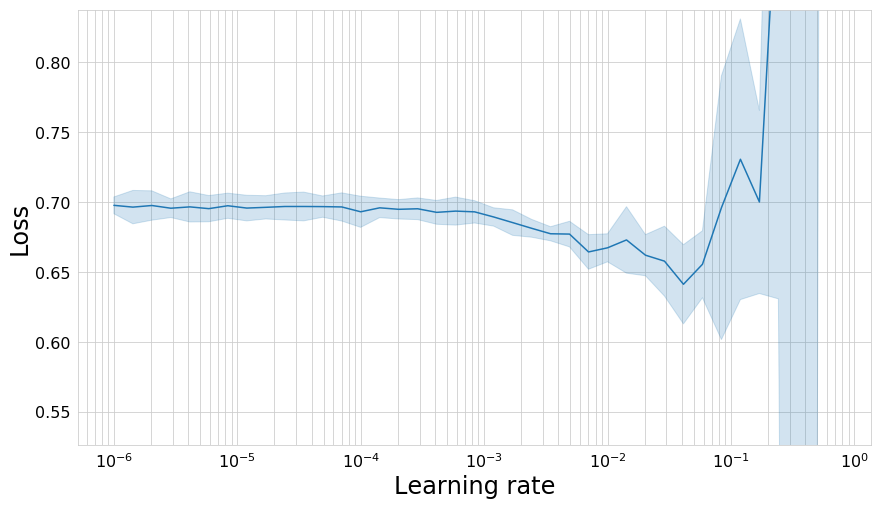

In [29]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

Training model 1 / 1, Val ID = 0


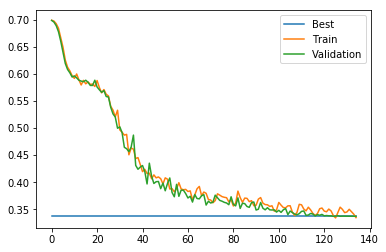

Early stopping after 135 epochs
Scores are: {'loss': 0.3371473252773285, 'AUC': 0.9176239272793135}
Fold took 101.734s


______________________________________
Training finished
Cross-validation took 101.744s 


<Figure size 432x288 with 0 Axes>

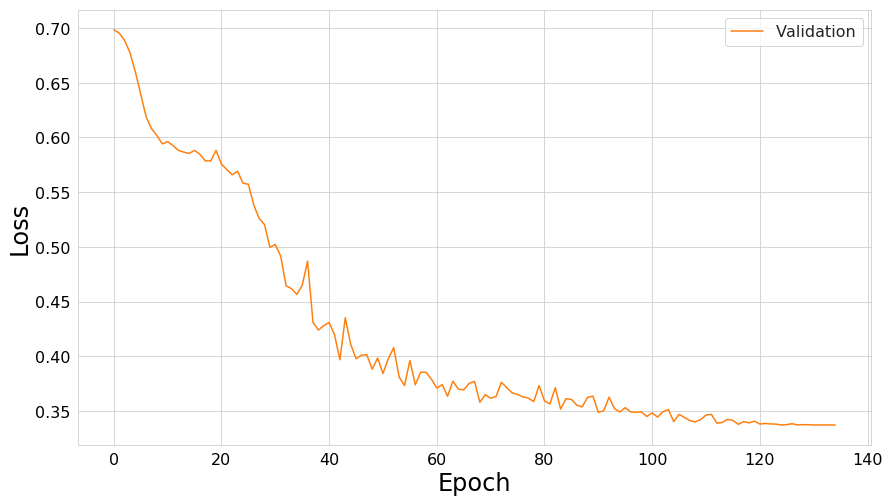

Mean loss = 0.3371473252773285±0.0
Mean AUC = 0.9176239272793135±0.0
______________________________________



In [30]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

## CNN

In [31]:
class CNN(AbsConv1dHead):
    def get_layers(self, in_c:int, act:str='relu', bn:bool=False, **kargs) -> Tuple[nn.Module, int]:    
        layers = []
        layers.append(self.get_conv1d_block(in_c, 16, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_block(16, 16, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_block(16, 32, stride=2, kernel_sz=3, act=act, bn=bn))
        layers.append(nn.AdaptiveAvgPool1d(1))
        layers = nn.Sequential(*layers)
        return layers

In [32]:
head = partial(CNN, vecs=vecs, feats_per_vec=fpv, act='swish', bn=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): CNN(
    (layers): Sequential(
      (0): Conv1DBlock(
        (layers): Sequential(
          (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
          (1): Swish()
          (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (1): Conv1DBlock(
        

LR finder took 9.565s 


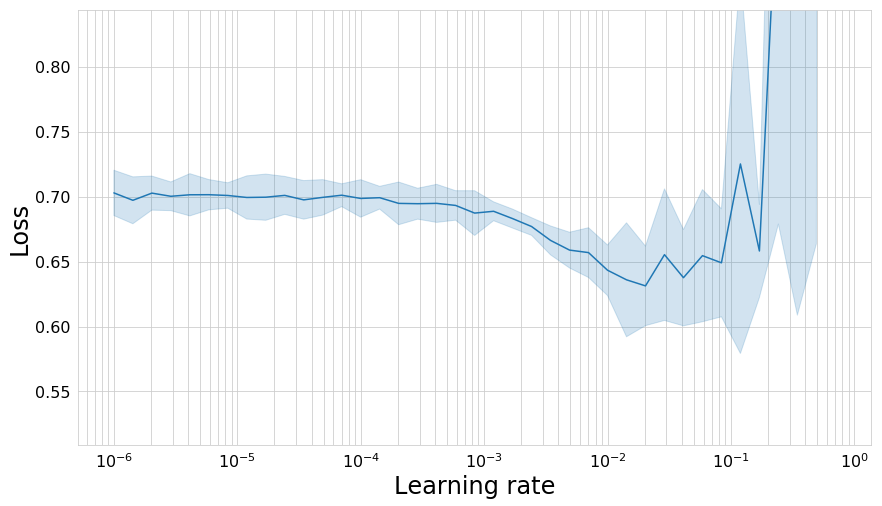

In [33]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

Training model 1 / 1, Val ID = 0


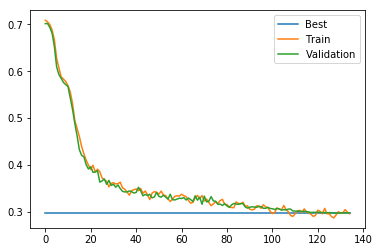

Early stopping after 135 epochs
Scores are: {'loss': 0.296759694814682, 'AUC': 0.937833700213568}
Fold took 102.475s


______________________________________
Training finished
Cross-validation took 102.486s 


<Figure size 432x288 with 0 Axes>

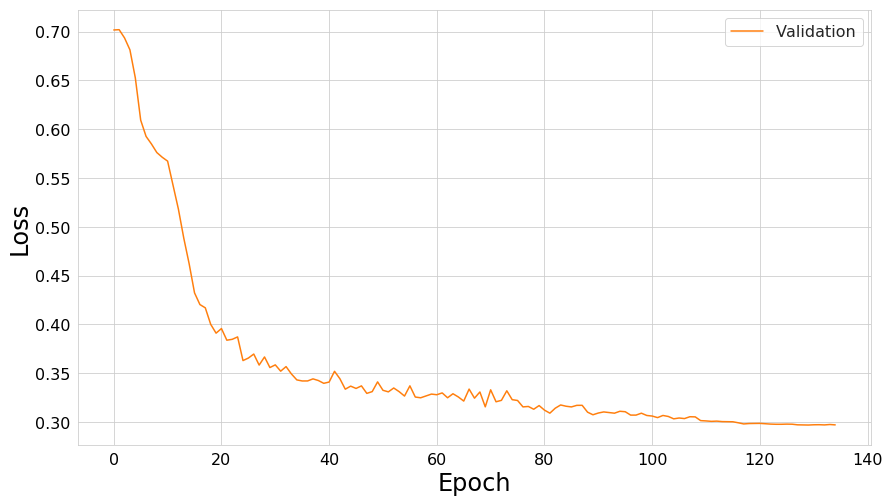

Mean loss = 0.296759694814682±0.0
Mean AUC = 0.937833700213568±0.0
______________________________________



In [34]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

## ResNet

In [35]:
class ResNet(AbsConv1dHead):
    def get_layers(self, in_c:int, act:str='relu', bn:bool=False, **kargs) -> Tuple[nn.Module, int]:    
        layers = []
        layers.append(self.get_conv1d_block(in_c, 16, stride=1, kernel_sz=3, act='linear', bn=False))
        layers.append(self.get_conv1d_res_block(16, 16, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_res_block(16, 32, stride=2, kernel_sz=3, act=act, bn=bn))
        layers.append(nn.AdaptiveAvgPool1d(1))
        layers = nn.Sequential(*layers)
        return layers

In [36]:
head = partial(ResNet, vecs=vecs, feats_per_vec=fpv, act='swish', bn=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): ResNet(
    (layers): Sequential(
      (0): Conv1DBlock(
        (layers): Sequential(
          (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): Res1DBlock(
        (layers): Sequential(
          (0): Sequential(
            (0): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=Tr

LR finder took 9.683s 


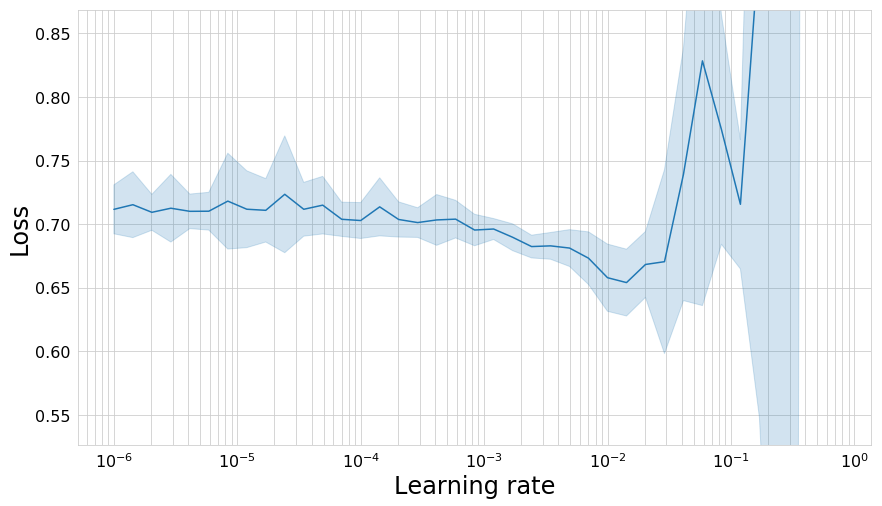

In [37]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

Training model 1 / 1, Val ID = 0


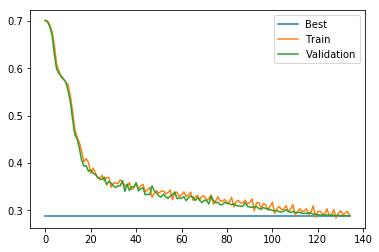

Early stopping after 135 epochs
Scores are: {'loss': 0.2887329161167145, 'AUC': 0.9408240821274125}
Fold took 109.975s


______________________________________
Training finished
Cross-validation took 109.985s 


<Figure size 432x288 with 0 Axes>

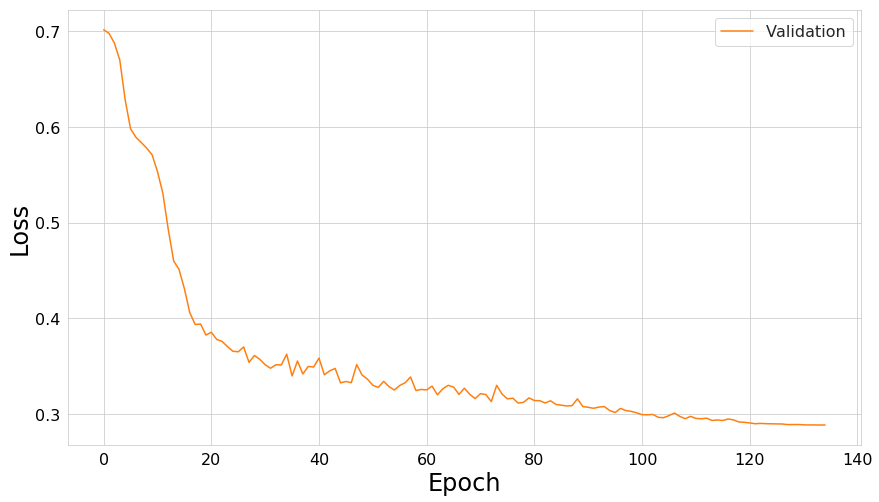

Mean loss = 0.2887329161167145±0.0
Mean AUC = 0.9408240821274125±0.0
______________________________________



In [38]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

## ResNeXt

In [39]:
class ResNeXt(AbsConv1dHead):
    def get_layers(self, in_c:int, act:str='relu', bn:bool=False, **kargs) -> Tuple[nn.Module, int]:    
        layers = []
        layers.append(self.get_conv1d_block(in_c, 32, stride=1, kernel_sz=3, act='linear', bn=False))
        layers.append(self.get_conv1d_resNeXt_block(32, 4,4,32, stride=1, kernel_sz=3, act=act, bn=bn))
        layers.append(self.get_conv1d_resNeXt_block(32, 4,4,64, stride=2, kernel_sz=3, act=act, bn=bn))
        layers.append(nn.AdaptiveAvgPool1d(1))
        layers = nn.Sequential(*layers)
        return layers

In [40]:
head = partial(ResNeXt, vecs=vecs, feats_per_vec=fpv, act='swish', bn=True)
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): ResNeXt(
    (layers): Sequential(
      (0): Conv1DBlock(
        (layers): Sequential(
          (0): Conv1d(4, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        )
      )
      (1): ResNeXt1DBlock(
        (layers): Sequential(
          (0): Sequential(
            (0): BatchNorm1d(32, eps=1e-05, momentum=0.1, affi

LR finder took 10.552s 


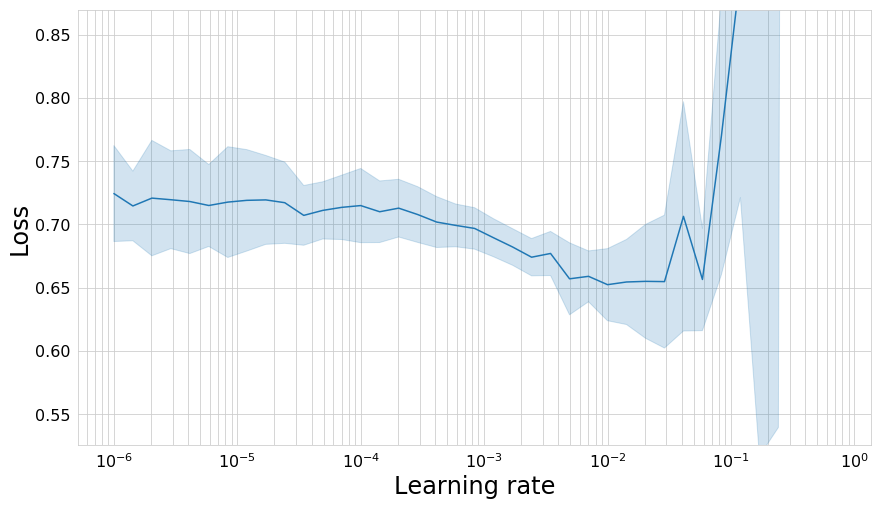

In [41]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

Training model 1 / 1, Val ID = 0


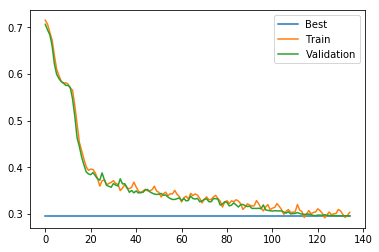

Early stopping after 135 epochs
Scores are: {'loss': 0.2958349883556366, 'AUC': 0.93647985934711}
Fold took 118.471s


______________________________________
Training finished
Cross-validation took 118.480s 


<Figure size 432x288 with 0 Axes>

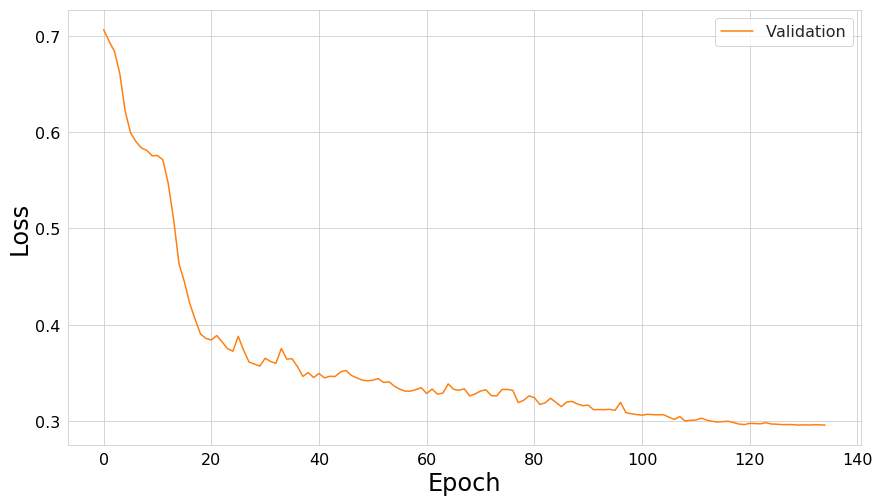

Mean loss = 0.2958349883556366±0.0
Mean AUC = 0.93647985934711±0.0
______________________________________



In [42]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)

## Interaction Net

In [57]:
head = partial(InteractionNet, intfunc_depth=3,intfunc_width=20,intfunc_out_sz=10,
               outfunc_depth=3,outfunc_width=20,outfunc_out_sz=4,agg_method='flatten',
               feats_per_vec=fpv,vecs=vecs, act='swish')
model_builder = get_model_builder(train_fy, depth=3, width=50, head=head)

Inputs:
60 Continuous: ['0_e', '0_px', '0_py', '0_pz', '1_e', '1_px', '1_py', '1_pz', '2_e', '2_px', '2_py', '2_pz', '3_e', '3_px', '3_py', '3_pz', '4_e', '4_px', '4_py', '4_pz', '5_e', '5_px', '5_py', '5_pz', '6_e', '6_px', '6_py', '6_pz', '7_e', '7_px', '7_py', '7_pz', '8_e', '8_px', '8_py', '8_pz', '9_e', '9_px', '9_py', '9_pz', '10_e', '10_px', '10_py', '10_pz', '11_e', '11_px', '11_py', '11_pz', '12_e', '12_px', '12_py', '12_pz', '13_e', '13_px', '13_py', '13_pz', '14_e', '14_px', '14_py', '14_pz']
                   
0  Categorical: []
                   
0  Matrix elements: []
                   

Model:
<bound method Module.parameters of Sequential(
  (0): InteractionNet(
    (fr): Sequential(
      (0): Sequential(
        (0): Linear(in_features=8, out_features=20, bias=True)
        (1): Swish()
      )
      (1): Sequential(
        (0): Linear(in_features=20, out_features=20, bias=True)
        (1): Swish()
      )
      (2): Sequential(
        (0): Linear(in_features=20,

LR finder took 8.319s 


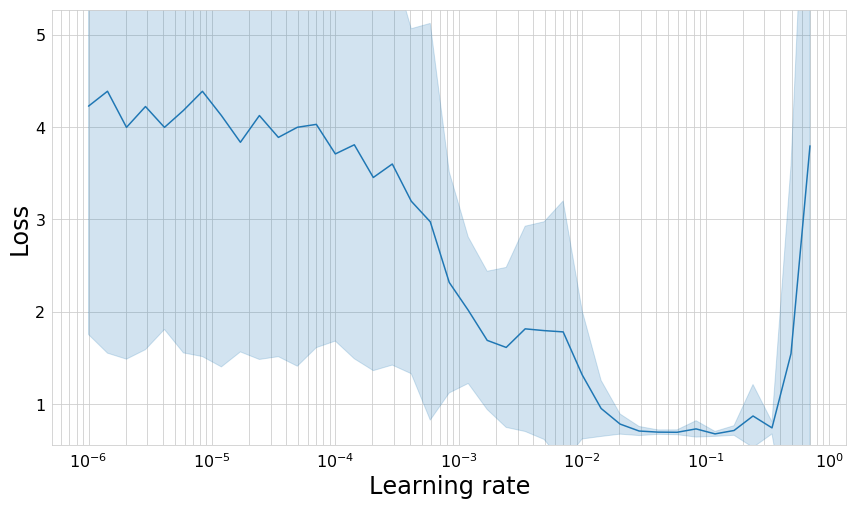

In [58]:
lr_finder = fold_lr_find(train_fy, model_builder, bs, lr_bounds=[1e-6,1e0])

In [59]:
callback_partials[0].keywords['lr_range'] = [3e-4, 3e-2]

Training model 1 / 1, Val ID = 0


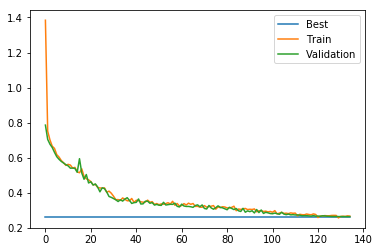

Early stopping after 135 epochs
Scores are: {'loss': 0.26311248540878296, 'AUC': 0.952135309366598}
Fold took 101.924s


______________________________________
Training finished
Cross-validation took 101.932s 


<Figure size 432x288 with 0 Axes>

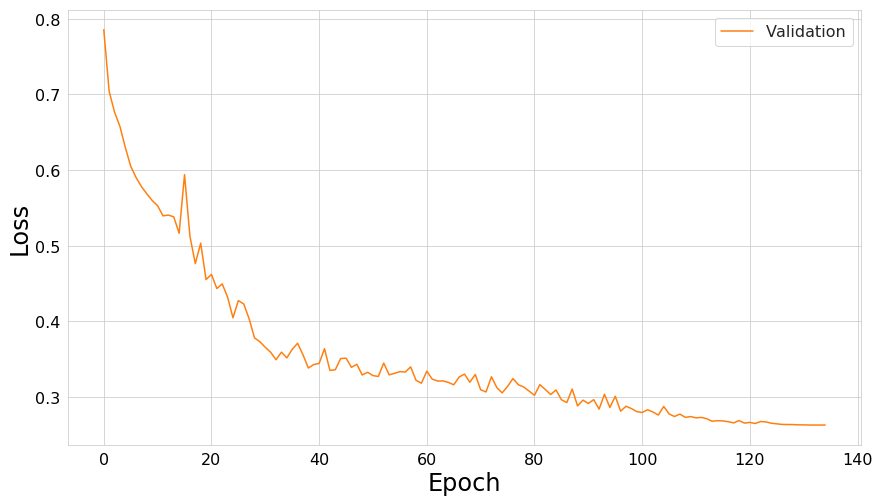

Mean loss = 0.26311248540878296±0.0
Mean AUC = 0.952135309366598±0.0
______________________________________



In [60]:
_ = fold_train_ensemble(train_fy, n_models=1,
                        model_builder=model_builder,
                        bs=bs,
                        callback_partials=callback_partials,
                        eval_metrics=eval_metrics,
                        max_epochs=15, patience=15)